## Week 6: Bayesian Logistic Regression

This week, we are going to explore logistic regression. Note that training a logistic regression with scipy is just 3-4 lines of code (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). However, here we'd aim to develop this from the first principles (as we have seen during the lectures).

So, the aims are:

- Practice training Logistic regression classifier with Stochastic Gradient Descent (SGD)
- Derive a generalisation (recall the Menti quiz during the class) to formulate and implement the hyper-parameter based approach.

In [42]:
import numpy as np
import pylab as plt
%matplotlib inline

#### Task Logistic regression classifier with SGD

##### Task 1: Load data
We use the attached data file `trainx.csv`.

In [48]:
def loadData(datafile):
    x = np.loadtxt(datafile, delimiter=',')
    y = x[:,2]
    x = x[:,0:2]
    return x, y

In [49]:
X_train, Y_train = loadData('trainx.csv')
X_test, Y_test = loadData('testx.csv')

print(X_train[:5])
print(Y_train[:5])
print(X_test[:5])
print(Y_test[:5])

[[-0.41222058 -1.21413869]
 [-0.13901063 -0.2783905 ]
 [ 0.68069227 -0.07414107]
 [-0.36867783 -0.5008379 ]
 [ 0.77597322 -1.12524486]]
[0. 0. 0. 0. 0.]
[[-0.59683866  0.7702523 ]
 [-2.08925658  0.80556957]
 [ 0.85850141 -0.61450625]
 [-1.79591442 -0.00508336]
 [ 0.30368919  0.3144538 ]]
[0. 0. 0. 0. 0.]


In [50]:
def plotData(X, Y):
    plt.figure()
    pos0 = np.where(Y==0)[0]
    pos1 = np.where(Y==1)[0]
    plt.plot(X[pos0,0],X[pos0,1],'ro')
    plt.plot(X[pos1,0],X[pos1,1],'bo')

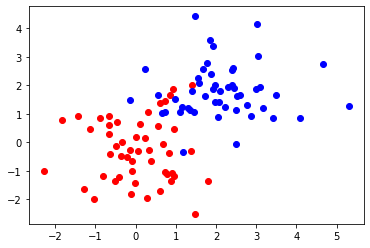

In [51]:
plotData(X_train, Y_train)

##### Task 2:  Gradient Descent Updates for Logistic Regression
**Make sure you understand the following equations and their roles (see Lecture notes for Week 6):**

Likelihood per data point: 
$$J(\theta) = \log p(y|\mathbf{x},\theta) = y \log(\sigma(\theta^T \mathbf{x})) + (1-y) \log(1 - \sigma(\theta^T \mathbf{x}))  $$
where $\sigma(z) = \frac{1} {1+ \exp(-z)}$

Joint Likelihood for a batch (subset of size $N$) or even the entire training set: 
$$J(\theta) = \log p(Y|\mathbf{X},\theta) = \sum_{i=1}^{N} y_i \log(\sigma(\theta^T \mathbf{x}_i)) + (1-y) \log(1 - \sigma(\theta^T \mathbf{x}_i))$$


Gradient update:
$$\frac{\partial}{\partial \theta_j}J(\theta) = (y - \sigma(\theta^T\mathbf{x}))x_j$$

Make sure that you go through the lecture notes and understand the sketch for the derivation (ask the GTAs or the lecturer if you're having difficulties with the derivation).


**TASK:** Write your own Python function implementations for the sigmoid, the objective function for Logistic regression, and its gradient

We are going to use a minimizer to get the MAP solution, so make sure your objective function and its gradient return the negative of the original one, i.e., we work with Negative Log Likelihood (NLL). 

In [52]:
class MyLogisticRegression:
    def __init__(self, n_iters=1000):
        #Insert your code here
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.losses = []
         
    #Sigmoid method
    def _sigmoid(self, x):
        #Insert your code here
        return 1 / (1 + np.exp(-x))

    def compute_loss(self, y_true, y_pred):
        # Insert your code here
        # binary cross entropy
        epsilon = 1e-9
        y1 = y_true * np.log(y_pred + epsilon)
        y2 = (1-y_true) * np.log(1 - y_pred + epsilon)
        return -np.mean(y1 + y2)

    def feed_forward(self,X):
        z = np.dot(X, self.weights) + self.bias
        A = self._sigmoid(z)
        return A

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # init parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        # gradient descent
        for _ in range(self.n_iters):
            A = self.feed_forward(X)
            self.losses.append(self.compute_loss(y,A))
            dz = A - y # derivative of sigmoid and bce X.T*(A-y)
            # compute gradients
            dw = (1 / n_samples) * np.dot(X.T, dz)
            db = (1 / n_samples) * np.sum(dz)
            # update parameters
            self.weights -= dw
            self.bias -= db

    def predict_prob(self, X):
        threshold = .5
        y_hat = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(y_hat)        
        return y_predicted
    
    def predict(self, X):
        #Insert your code here
        threshold = .5
        y_hat = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(y_hat)
        y_predicted_cls = [1 if i > threshold else 0 for i in y_predicted]
        
        return np.array(y_predicted_cls)

In [54]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

model = MyLogisticRegression(n_iters=1000)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

print("Precision: {0:.3f}".format(precision_score(Y_test, Y_pred, average="macro")))
print("Recall: {0:.3f}".format(recall_score(Y_test, Y_pred, average="macro")))
print("F-score: {0:.3f}".format(f1_score(Y_test, Y_pred, average="macro")))


Precision: 0.878
Recall: 0.877
F-score: 0.877


We now implement a function to show the decision boundary (iso-posterior lines or contours)

In [55]:
def plotContours(X, Y, model):
    xvals = np.arange(-5,5,0.2)
    Ngrid = len(xvals)
    gridpred = np.zeros((Ngrid,Ngrid))
    for i in range(len(xvals)):
        for j in range(len(xvals)):
            gridpred[i][j] = model.predict_prob([xvals[i], xvals[j]])            
    
    plt.figure()
    
    plotData(X, Y)
    
    A = plt.contour(xvals, xvals, gridpred.T, linewidths=1)
    plt.clabel(A, inline=1, fontsize=15)

<Figure size 432x288 with 0 Axes>

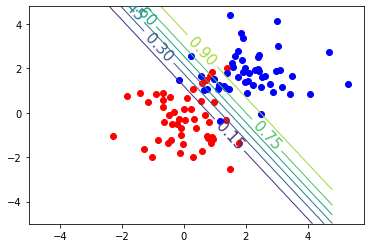

In [56]:
plotContours(X_train, Y_train, model)

##### Task 3:  Gradient Descent Updates for Generalized Logistic Regression

We are now going to extend the basic logistic regression algorithm with the learning rate parameter.

**TASK** Recompute the gradient when the activation is $g(z) = 1/(1+e^{-\alpha z})$, where $\alpha \in \mathbb{R}$ is a scalar. **Is the gradient now a function of $\alpha$**?

$$g'(z) = \frac{d}{dz} \frac{1}{1+e^{-\alpha z}}$$

$$= \frac{-1}{(1+e^{-\alpha z})^2} \frac{d}{dz}e^{-\alpha z}$$

$$= \frac{-1}{(1+e^{-z})^2} e^{-\alpha z} \frac{d}{dz}(-\alpha z)$$

$$= \alpha(\frac{1}{1+e^{-\alpha z}}) (\frac{e^{-\alpha z}}{1+e^{-\alpha z}}) = \alpha g(z)(1-g(z))$$

$$
l(\theta) = \log L(\theta) = y\log g(\theta^T \vec{x}) + (1-y)(1-\log g(\theta^T \vec{x}))
$$

$$\frac{\partial}{\partial \theta_j}l(\theta)=(y\frac{1}{g(\theta^Tx)} - (1-y)\frac{1}{1-g(\theta^Tx)})\underbrace{\frac{\partial}{\partial \theta_j}g(\theta^Tx)}_{\text{we computed this}}$$


$$=(y\frac{1}{g(\theta^Tx)} - (1-y)\frac{1}{1-g(\theta^Tx)})\underbrace{\alpha g(\theta^Tx)(1-g(\theta^Tx))}_{\text{substituted!}} \underbrace{\frac{\partial}{\partial \theta_j}\theta^Tx}_{\text{this is:}\,\theta_j x_j}$$

Thus:
$$\frac{\partial}{\partial \theta_j}l(\theta)=(y-\alpha g(\theta^Tx))x_j$$






**TASK** Now based on your derivation, write your own Python function implementations for the modified sigmoid, the objective function for Logistic regression, and its gradient.

In [57]:
class MyGeneralisedLogisticRegression:
    def __init__(self, n_iters=1000,alpha=1):
        #Insert your code here
        self.alpha = alpha
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.losses = []
         
    #Sigmoid method
    def _sigmoid(self, x):
        #Insert your code here
        return 1 / (1 + np.exp(-self.alpha * x))

    def compute_loss(self, y_true, y_pred):
        # Insert your code here
        # binary cross entropy
        epsilon = 1e-9
        y1 = y_true * np.log(y_pred + epsilon)
        y2 = (1-y_true) * np.log(1 - y_pred + epsilon)
        return -np.mean(y1 + y2)

    def feed_forward(self,X):
        z = np.dot(X, self.weights) + self.bias
        A = self._sigmoid(z)
        return A

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # init parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        # gradient descent
        for _ in range(self.n_iters):
            A = self.feed_forward(X)
            self.losses.append(self.compute_loss(y,A))
            dz = A - y # derivative of sigmoid and bce X.T*(A-y)
            # compute gradients
            dw = (1 / n_samples) * np.dot(X.T, dz)
            db = (1 / n_samples) * np.sum(dz)
            # update parameters
            self.weights -= self.alpha * dw
            self.bias -= self.alpha * db

    def predict_prob(self, X):
        threshold = .5
        y_hat = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(y_hat)        
        return y_predicted
    
    def predict(self, X):
        #Insert your code here
        threshold = .5
        y_hat = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(y_hat)
        y_predicted_cls = [1 if i > threshold else 0 for i in y_predicted]
        
        return np.array(y_predicted_cls)

In [58]:
model = MyGeneralisedLogisticRegression(alpha=0.1, n_iters=1000)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

print("Precision: {0:.3f}".format(precision_score(Y_test, Y_pred, average="macro")))
print("Recall: {0:.3f}".format(recall_score(Y_test, Y_pred, average="macro")))
print("F-score: {0:.3f}".format(f1_score(Y_test, Y_pred, average="macro")))


Precision: 0.891
Recall: 0.875
F-score: 0.874


##### Task 4: Plot the decision boundaries and Observe

Plot the decision boundaries obtained with the generalized model and compare with the previous results. Explain what changes and why?

<Figure size 432x288 with 0 Axes>

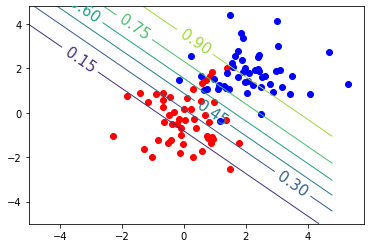

In [59]:
plotContours(X_train, Y_train, model)

##### Task 5: Vary the hyper-parameter $\alpha$ and see what changes! Try to explain why.

No solution is provided for this.